In [1]:
import numpy as np
import pandas as pd
from missingpy import MissForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer

import matplotlib.pyplot as plt

# Reading Dataset

In [2]:
# Read the dataset
raw = pd.read_csv("data/nyc_taxi.csv",low_memory=False)
raw['timestamp'] = pd.to_datetime(raw['timestamp'])

# Preview raw dataset
raw

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [3]:
# The times of anomaly events (Ground Truth)
anomaly_points = [
        [
            "2014-10-30 15:30:00.000000",
            "2014-11-03 22:30:00.000000"
        ],
        [
            "2014-11-25 12:00:00.000000",
            "2014-11-29 19:00:00.000000"
        ],
        [
            "2014-12-23 11:30:00.000000",
            "2014-12-27 18:30:00.000000"
        ],
        [
            "2014-12-29 21:30:00.000000",
            "2015-01-03 04:30:00.000000"
        ],
        [
            "2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"
        ]
]

# Labeling: if anomaly then 1 else 0
raw['anomaly'] = 0  # Set default values
for start, end in anomaly_points:
    raw.loc[((raw['timestamp'] >= start) & (raw['timestamp'] <= end)), 'anomaly'] = 1

# Preview labeled raw dataset
raw

,timestamp,value,anomaly
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0
...,...,...,...
10315,2015-01-31 21:30:00,24670,0
10316,2015-01-31 22:00:00,25721,0
10317,2015-01-31 22:30:00,27309,0
10318,2015-01-31 23:00:00,26591,0


In [4]:
raw['anomaly'].value_counts()

0    9285
1    1035
Name: anomaly, dtype: int64

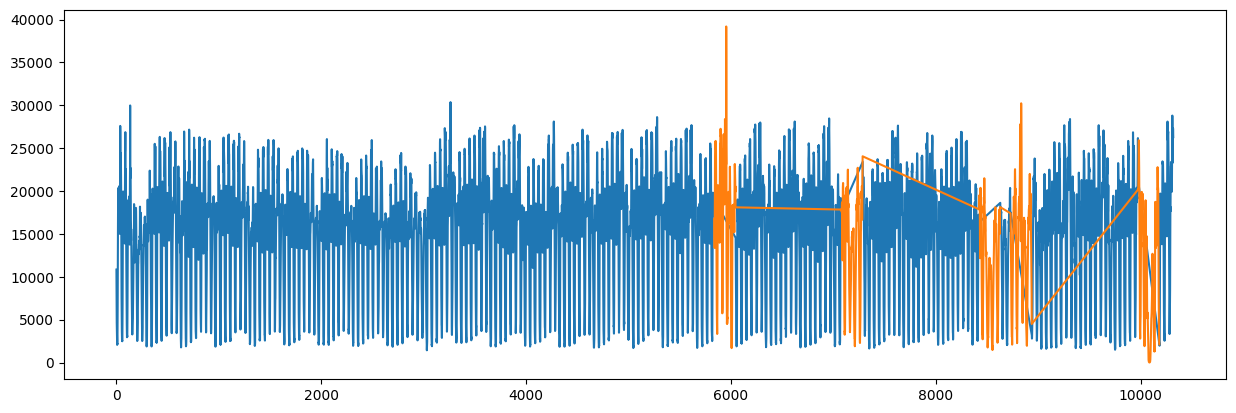

In [34]:
plt.figure().set_figwidth(15)
plt.plot(raw[raw['anomaly'] == 0].index, raw[raw['anomaly'] == 0]['value'])
plt.plot(raw[raw['anomaly'] == 1].index, raw[raw['anomaly'] == 1]['value'])
plt.show()

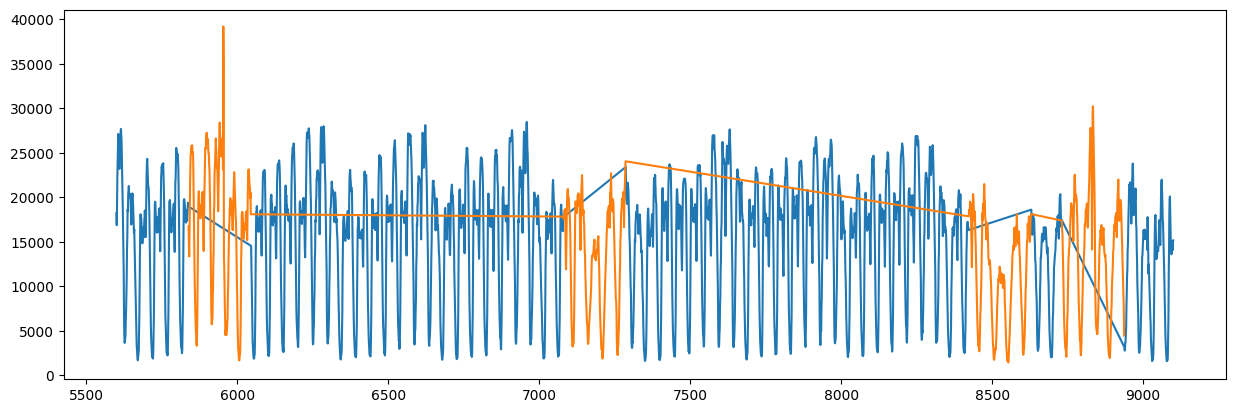

In [43]:
n=5600
m=9100
plt.figure().set_figwidth(15)
plt.plot(raw[raw['anomaly'] == 0].loc[n:m,:].index, raw[raw['anomaly'] == 0].loc[n:m,:]['value'])
plt.plot(raw[raw['anomaly'] == 1].loc[n:m,:].index, raw[raw['anomaly'] == 1].loc[n:m,:]['value'])
plt.show()

# Preprocessing

In [ ]:
# Convert the timestamp
df = pd.DataFrame()
df['year'] = raw['timestamp'].dt.year
df['month'] = raw['timestamp'].dt.month
df['day'] = raw['timestamp'].dt.day
df['hour'] = raw['timestamp'].dt.hour
df['value'] = raw['value']
df['anomaly'] = raw['anomaly']

# delete unused dataframe
del raw

In [ ]:
# Preview dataset
df

In [ ]:
# Calculate 80% of the number of rows for training
num_rows = int(0.8 * len(df))

# Get the first part of the DataFrame
df_train = df[:num_rows]
# Get the remaining part of the DataFrame
df_test = df[num_rows:]

# delete unused dataframe
del df

In [ ]:
df_train['anomaly'].value_counts()

In [ ]:
df_test['anomaly'].value_counts()

# Metrix Calculation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler


# Root Square Error
def RSE(original, filled):
    score = np.sqrt(np.power(original-filled,2))
    return score


# Absolute Error
def AE(original, filled):
    score = np.absolute(original-filled)
    return score


# Absolute Percentage Error
def APE(original, filled):
    score = np.absolute(original-filled)/original
    return score


# Root Mean Square Error
def RMSE(original, filled):
    score = mean_squared_error(original, filled, squared=False)
    return score


# Mean Absolute Error
def MAE(original, filled):
    score = mean_absolute_error(original, filled)
    return score


# Mean Absolute Percentage Error
def MAPE(original, filled):
    score = mean_absolute_percentage_error(original, filled)
    return score


def metric_RMSE_MAE_MAPE(original, filled):
    rmse = RMSE(original, filled)
    print("RMSE=", rmse)

    mae = MAE(original, filled)
    print("MAE=", mae)

    mape = MAPE(original, filled)
    print("MAPE=", mape)

    return rmse, mae, mape


def metric_RSE_AE_APE(original, filled):
    rmse = RSE(original, filled)
    print("RSE=", rmse)

    mae = AE(original, filled)
    print("AE=", mae)

    mape = APE(original, filled)
    print("APE=", mape)

    return rmse, mae, mape

# DEBUG
# a = np.array([10, 20])
# b = np.array([12, 22])

# print("RSE=", RSE(a, b))
# print("AE=", AE(a, b))
# print("AP=", APE(a, b))
# print("RMSE=", RMSE(a, b))
# print("MAE=", MAE(a, b))
# print("MAPE=", MAPE(a, b))

# Finding Threshold

In [ ]:
def train(imputer, X, y, percentage=0.1, imputed_col=-1):
    # Calculate the number of rows to select (10% of the total rows)
    num_rows_to_select = int(percentage * X.shape[0])

    # Randomly select row indices to change
    random_indices = np.random.choice(X.shape[0], size=num_rows_to_select, replace=False)

    # Change the value column to NaN for the selected rows
    X[random_indices, imputed_col] = np.nan

    X_imputation = imputer.fit_transform(X)

    # The results of the training process is the RMSE, MAE, and MAPE values
    return imputer, metric_RMSE_MAE_MAPE(y[random_indices], X_imputation[random_indices, imputed_col])



In [ ]:
# Get normal training data then convert it to numpy float
X = df_train[df_train['anomaly'] == 0].drop(columns=['anomaly']).to_numpy(dtype=float)
# Copy the 'value' column of normal training data
y = X[:, -1].copy()

imputer = IterativeImputer(max_iter=100, random_state=0)
imputer, (rmse, mae, mape) = train(imputer, X, y)

In [ ]:
# Get normal training data then convert it to numpy float
X = df_train.drop(columns=['anomaly']).to_numpy(dtype=float)
label = df_train['anomaly'].to_numpy()

for i in range(X.shape[0]):
    if label[i] == 0:
        continue

    y = X[i,-1]
    X[i,-1] = np.nan
    y_imputation = imputer.transform(X)
    print("y=", y, ", y'=", y_imputation[i,-1])
    print("label=", label[i])
    rmse, mae, mape = metric_RSE_AE_APE(y, y_imputation[i,-1])
    X[i,-1] = y
    # break